In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from typing import List, Tuple, Union
from dataclasses import dataclass
from scipy.spatial import distance

/home/morita/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@dataclass
class Source:
    """
    Create point radiation source.

    Examples
    --------
    >>> Source([1, 2, 3], 2.0)
    Source(loc=[1, 2, 3], intensity=2.0)
    """

    #: Location of the radiation source such that [x, y, z] [m].
    loc: List[float]
    #: Intensity of the radiation source [MBq]. (default is 1.0)
    intensity: float = 1.0


@dataclass
class AreaSource:
    """
    Create area radiation source. The shape is only square at this moment,
    and normal vector is along the z-axis.

    Examples
    --------
    >>> AreaSource([1, 2, 3], 2.0)
    AreaSource(bl_loc=[1, 2, 3], width=2.0, intensity=1.0, div_num=20)
    """

    #: Location of the bottom left of the radiation source such that [x, y, z] [m].
    bl_loc: List[float]
    #: Width of the square radiation area source [m].
    width: float
    #: Intensity of the radiation source [MBq]. (default is 1.0)
    intensity: float = 1.0
    #: Area source is divided into div_num*div_num point sources. (default is 20)
    div_num: int = 20


@dataclass
class Detector:
    """
    Create radiation detector. The detector only measures count.

    Examples
    --------
    >>> Detector([1, 2, 3], 2.0)
    Detector(loc=[1, 2, 3], duration=2.0, factor=5)
    """

    #: Location of the detector such that [x, y, z] [m].
    loc: List[float]
    #: Measurement time of the detector `t` [s]. (default is 10)
    duration: float = 10
    #: Factor to consider counting efficiency, size, etc. `f` (default is 5)
    #: `mu` of Poisson distribution is calculated as follows:
    #: `mu` = `ftq`/`d^2`,
    #: where `d` is the distance between the detector and sources.
    factor: float = 5


class World(object):
    """
    Create world for adding radiation sources and detectors.
    """

    def __init__(self):
        self.sources: List[Source] = []

    def __repr__(self) -> str:
        repr_str = f"{self.__class__}: contains {len(self.sources)} sources.\n"
        src_str = ",\n ".join([str(it) for it in self.sources])
        repr_str = f"{repr_str}[\n {src_str}\n]"
        return repr_str

    def add_source(self, source: Source):
        """
        Add radiation point source.

        Parameters
        ----------
        source: Source
            Radiation point source.
        """
        self.sources.append(source)

    def add_area_source(self, source: AreaSource):
        """
        Add radiation area source.
        Internally, area source is converted multiple point sources.

        Parameters
        ----------
        source: AreaSource
            Radiation area source.
        """

        # bottom left location
        bl = source.bl_loc
        q = source.intensity / source.div_num ** 2
        x_lin = np.linspace(bl[0], bl[0] + source.width, source.div_num)
        y_lin = np.linspace(bl[1], bl[1] + source.width, source.div_num)
        x_grid, y_grid = np.meshgrid(x_lin, y_lin)
        for x, y in zip(x_grid.flatten(), y_grid.flatten()):
            self.add_source(Source(loc=[x, y, bl[2]], intensity=q))

    def get_measuments(self, detectors: Union[List[Detector], Detector]) -> np.ndarray:
        """
        Get measurement without background noise.
        Internally, area source is converted multiple point sources.

        Parameters
        ----------
        detectors: List[Detector]
            List of detectors.

        Returns
        -------
        counts: ndarray
            Counts measured by the detectors
        """
        # To list if detectors is Detector class
        if not isinstance(detectors, list):
            detectors = [detectors]

        # detectors loc
        locs = np.stack([d.loc for d in detectors])

        # detector factors
        factors = np.stack([d.duration * d.factor for d in detectors])

        # sources
        srcs = np.stack([src.loc for src in self.sources])

        # intensity
        q = np.array([src.intensity for src in self.sources])

        dist = distance.cdist(locs, srcs)
        assert not np.any(
            dist == 0
        ), "zero division. Distance between source and detector should not be zero"

        # mu for possion distribution
        mu = factors[..., np.newaxis] * q[np.newaxis, :] / dist ** 2

        # sum of possion distribution is possion distribution
        mu = mu.sum(axis=1)

        # measument counts
        counts = stats.poisson.rvs(mu)
        if not isinstance(counts, np.ndarray):
            # if len(detectors) == 1
            counts = np.array([counts])

        return counts

    def visualize_world(
        self,
        detectors: List[Detector] = [],
        figsize: Tuple[float, float] = (8, 8),
        plotsize: float = 10,
    ) -> plt.Axes:
        """
        Visualize radiation sources and detectors in world (X-Y plane).

        Parameters
        ----------
        detectors: List[Detector]
            List of detectors to be visualized. (default is [])
        figsize: tuple(float, float)
            figsize for plot.
        plotsize: float
            Plot in xy plane [-plotsize, plotsize] x [-plotsize, plotsize]

        Returns
        -------
        ax: plt.Axes
            Matplotlib axes
        """

        # Setup plot area
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.plot(
            [plotsize, plotsize, -plotsize, -plotsize],
            [plotsize, -plotsize, plotsize, -plotsize],
            "wd",
        )
        ax.plot([0], [0], "rd")
        ax.set_aspect("equal")
        detec_msg = "Detector (x)" if len(detectors) > 0 else ""
        ax.set_title(f"X (horizontal), Y (vertical), Origin (red dot) {detec_msg}")

        # Visualize sources
        x = []
        y = []
        c = []
        for src in self.sources:
            x.append(src.loc[0])
            y.append(src.loc[1])
            c.append(src.intensity)

        sc = ax.scatter(x, y, s=100, c=c, cmap=plt.cm.jet)
        _ = fig.colorbar(sc, orientation="horizontal")

        # Visualize detectors if not empty
        x_detec = []
        y_detec = []
        for d in detectors:
            x_detec.append(d.loc[0])
            y_detec.append(d.loc[1])
        ax.plot(x_detec, y_detec, "bx")

        return ax

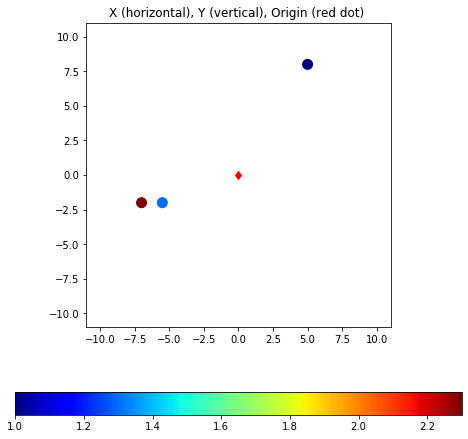

In [3]:
# Construct world
world = World()
world.add_source(Source(loc=[5,8,0], intensity=1))
# world.add_source(Source(loc=np.array([1,1,0.1]), intensity=0.3))
world.add_source(Source(loc=[-7,-2,0], intensity=2.3))
world.add_source(Source(loc=[-5.5,-2,0], intensity=1.3))

ax = world.visualize_world()

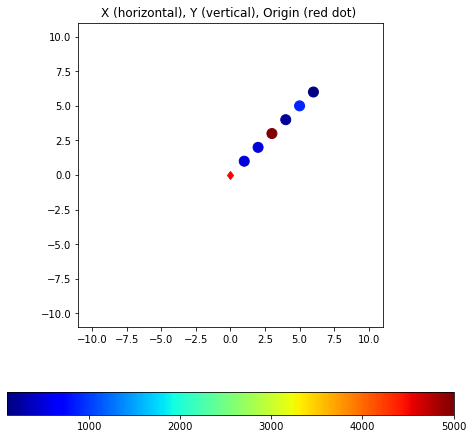

In [4]:
# Construct world
world = World()
world.add_source(Source(loc=np.array([1,1,0]), intensity=500))
world.add_source(Source(loc=np.array([2,2,0]), intensity=500))
world.add_source(Source(loc=np.array([3,3,0]), intensity=5000))
world.add_source(Source(loc=np.array([4,4,0]), intensity=200))
world.add_source(Source(loc=np.array([5,5,0]), intensity=900))
world.add_source(Source(loc=np.array([6,6,0]), intensity=100))

# # # Set area source
# world.add_area_source(AreaSource([2., -10], width=5, intensity=3.5))
# world.add_area_source(AreaSource([-8., 2], width=3, intensity=3))

ax = world.visualize_world()

In [5]:
# Set detectors
div_num = 20
x_lin = np.linspace(-10, 10, div_num)
y_lin = np.linspace(10, -10, div_num)
x_grid, y_grid = np.meshgrid(x_lin, y_lin)

# Constant height
z = 1.5
detectors = []
for x, y in zip(x_grid.flatten(), y_grid.flatten()):
    detectors.append(Detector(loc=[x, y, z]))

[  1636   1784   2110   2385   2746   3132   3684   4301   4889   5783
   6233   6824   7429   7658   7488   6722   6204   5506   4592   3986
   1752   2033   2202   2705   3067   3616   4234   5050   6152   7063
   8116   9118  10029  10321  10075   9364   8158   6980   5638   4676
   1766   2091   2399   2903   3394   4065   4884   6060   7346   8900
  10682  12625  14104  15099  15106  13577  11115   8795   6892   5583
   1877   2104   2638   3088   3786   4633   5725   7066   8934  11834
  14754  18186  21399  23144  23404  20661  15763  11249   8178   6257
   2042   2303   2802   3329   3948   5038   6487   8331  10919  15071
  20590  27552  34052  38003  38789  31655  20592  13672   9336   6922
   2135   2327   2833   3444   4370   5403   7175   9416  13030  19221
  28699  43129  58430  61444  55434  38698  23645  14980  10498   7524
   2110   2383   3016   3549   4531   5703   7656  10331  14612  22571
  36866  64194 101742  95414  61581  38132  23339  15091  10355   7415
   208

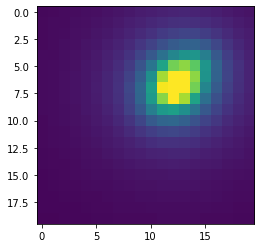

In [6]:
cnts = world.get_measuments(detectors)
print(cnts)
print(f"max_count: {cnts.max()}")
viz = cnts.reshape(div_num, div_num)
plt.imshow(viz, vmin=0, vmax=np.percentile(cnts, 99))

# Estimation of ground surface radiation sources from dose map measured by moving dosimeter and 3D map
10.1109/IROS.2014.6942811

In [7]:
def generate_grid(W=10, H=10, div_num = 25):
    x_lin = np.linspace(-W, W, div_num)
    y_lin = np.linspace(H, -H, div_num)
    x_grid, y_grid = np.meshgrid(x_lin, y_lin)
    return x_grid, y_grid

max_count: 124583


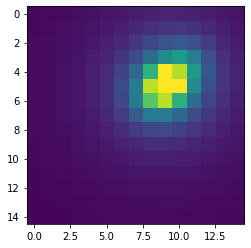

In [8]:
div_num = 15
# Set detectors
x_grid, y_grid = generate_grid(W=10, H=10, div_num=div_num)

# Constant height
z = 1.5
detectors = []
for x, y in zip(x_grid.flatten(), y_grid.flatten()):
    detectors.append(Detector(loc=np.array([x, y, z])))

cnts = world.get_measuments(detectors)
print(f"max_count: {cnts.max()}")
viz = cnts.reshape(div_num, div_num)
plt.imshow(viz, vmin=0, vmax=np.percentile(cnts, 99))

In [20]:
b_measure = cnts
x_b = np.array([it.loc for it in detectors])
print(x_b)
assert x_b.shape[0] == len(b_measure), 'Number of measument should be equal to number of position'

[[-10.          10.           1.5       ]
 [ -8.57142857  10.           1.5       ]
 [ -7.14285714  10.           1.5       ]
 [ -5.71428571  10.           1.5       ]
 [ -4.28571429  10.           1.5       ]
 [ -2.85714286  10.           1.5       ]
 [ -1.42857143  10.           1.5       ]
 [  0.          10.           1.5       ]
 [  1.42857143  10.           1.5       ]
 [  2.85714286  10.           1.5       ]
 [  4.28571429  10.           1.5       ]
 [  5.71428571  10.           1.5       ]
 [  7.14285714  10.           1.5       ]
 [  8.57142857  10.           1.5       ]
 [ 10.          10.           1.5       ]
 [-10.           8.57142857   1.5       ]
 [ -8.57142857   8.57142857   1.5       ]
 [ -7.14285714   8.57142857   1.5       ]
 [ -5.71428571   8.57142857   1.5       ]
 [ -4.28571429   8.57142857   1.5       ]
 [ -2.85714286   8.57142857   1.5       ]
 [ -1.42857143   8.57142857   1.5       ]
 [  0.           8.57142857   1.5       ]
 [  1.42857143   8.57142857   1.5 

In [25]:
# radiation source candidate
x_q = []
source_div_num = 14
x_grid, y_grid = generate_grid(W=10, H=10, div_num=source_div_num)
# radiation source should be z = 0
x_q = np.stack([x_grid, y_grid, np.zeros_like(x_grid)], axis=-1)
x_q = x_q.reshape(-1, 3)

# A matrix in Equation 3
dist = distance.cdist(x_b, x_q)

# TODO: Check again later. Might be wrong
factors = np.stack([d.duration * d.factor for d in detectors])[:, np.newaxis]

A = factors/dist**2

10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5
10
5


## Optimization
### Gradient decent

In [11]:
def score_func(q):
    global A, b_measure
    b_ave = A.dot(q)
    score = np.sum(b_measure*np.log(b_ave))-np.sum(b_ave)
    return score

def grad_func(q):
    global A, b_measure
    b_ave = A.dot(q)
    grad_tmp = (b_measure/b_ave)[:,np.newaxis]*A
    grad = grad_tmp.sum(axis=0) - A.sum(axis=0)
    return grad

In [12]:
# initial guess for radiation distribution
M = x_q.shape[0]
q_max = 10
q_init = 1/q_max
q = np.array([q_init]*M)
# b_ave = A.dot(q)
# plt.imshow(b_ave.reshape(div_num, div_num))

optim_factor = 0.00002
init_score = score_func(q)
print(f'initial score:{init_score}')

initial score:7139967.796688944


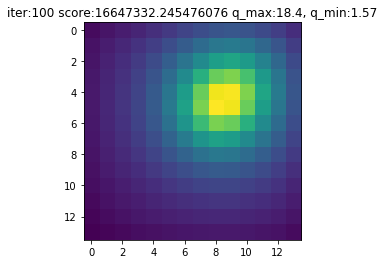

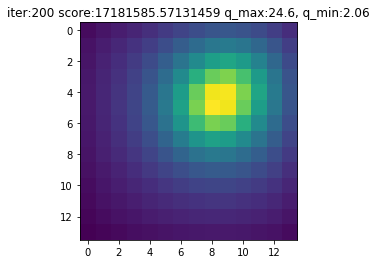

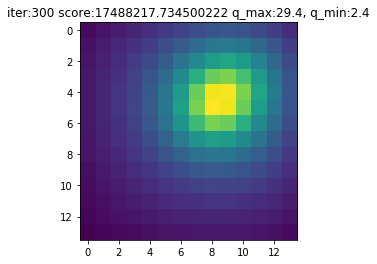

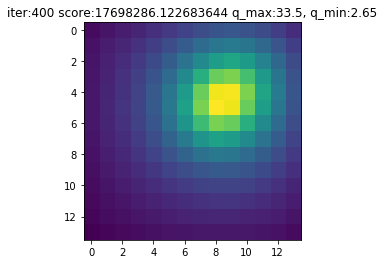

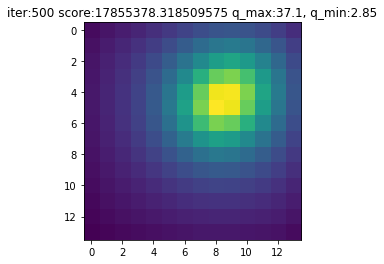

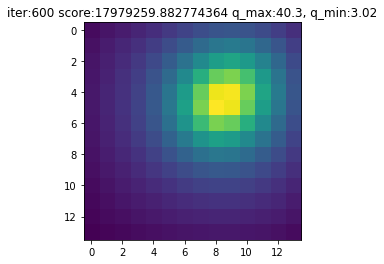

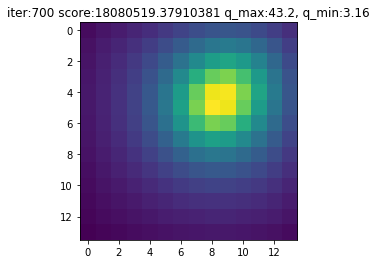

In [13]:
for i in range(1, 800):
    q_diff = grad_func(q)
    q += optim_factor*q_diff

    # bound > 0
    q[q<0]=0.0000001

    score = score_func(q)
    if i%100==0:
        plt.figure()
        plt.title(f'iter:{i} score:{score} q_max:{q.max():.3}, q_min:{q.min():.3}')
        plt.imshow(q.reshape(source_div_num, source_div_num))

## SLSQP
Sequential (least-squares) quadratic programming (SQP)



In [14]:
from scipy import optimize

In [15]:
# initial guess for radiation distribution
M = x_q.shape[0]
q_max = 10
q_init = 1/q_max
q = np.array([q_init]*M)

# bound
lb = [0.000000]*M
ub = [np.inf]*M
bounds = optimize.Bounds(lb, ub)

# method
method='SLSQP'
options={'disp': True, 'iprint':2}
# method='L-BFGS-B'
# options={'disp': True, 'iprint':101, 'maxfun': 150000}

# method='trust-constr'
# options={'disp': True, 'verbose':2}

# Formulated as error function
inv_score_fun = lambda x:-score_func(x)
inv_grad_fun = lambda x:-grad_func(x)

In [16]:
# gradient check
for _ in range(3):
    rand_q = np.random.rand(M)
    err = optimize.check_grad(inv_score_fun, inv_grad_fun, rand_q)
    err/=inv_grad_fun(rand_q).mean()
    print(f'Error ratio:{err:.4}')

Error ratio:-4.228e-05
Error ratio:-3.601e-05
Error ratio:-5.495e-05


In [17]:
res = optimize.minimize(inv_score_fun, q, method=method, bounds=bounds, options=options)
print(res.message)
print(f'Final score:{-res.fun}')

  NIT    FC           OBJFUN            GNORM
    1   198     6.120517E+09     1.955386E+06
    2   405    -1.896277E+07     2.608669E+03
    3   602    -1.923787E+07     1.899278E+03
    4   799    -1.935985E+07     1.634945E+03
    5   996    -1.942774E+07     1.494315E+03
    6  1193    -1.948318E+07     1.373361E+03
    7  1390    -1.950388E+07     1.269961E+03
    8  1587    -1.952118E+07     1.230346E+03
    9  1784    -1.953492E+07     1.191595E+03
   10  1981    -1.955644E+07     1.147694E+03
   11  2178    -1.959736E+07     1.082655E+03
   12  2375    -1.960294E+07     9.446283E+02
   13  2572    -1.960769E+07     9.274293E+02
   14  2769    -1.961141E+07     9.089477E+02
   15  2966    -1.962219E+07     8.806382E+02
   16  3163    -1.962297E+07     8.131760E+02
   17  3360    -1.962647E+07     8.151109E+02
   18  3557    -1.963014E+07     8.008891E+02
   19  3754    -1.963039E+07     7.872911E+02
   20  3951    -1.963164E+07     7.863426E+02
   21  4148    -1.963776E+07     7

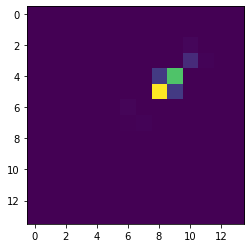

In [18]:
plt.imshow(res.x.reshape(source_div_num, source_div_num))

high intensity location:
 [[5.38461538 5.38461538 0.        ]
 [2.30769231 3.84615385 0.        ]
 [3.84615385 3.84615385 0.        ]
 [2.30769231 2.30769231 0.        ]
 [3.84615385 2.30769231 0.        ]]
Source(loc=array([1, 1, 0]), intensity=500)
Source(loc=array([2, 2, 0]), intensity=500)
Source(loc=array([3, 3, 0]), intensity=5000)
Source(loc=array([4, 4, 0]), intensity=200)
Source(loc=array([5, 5, 0]), intensity=900)
Source(loc=array([6, 6, 0]), intensity=100)


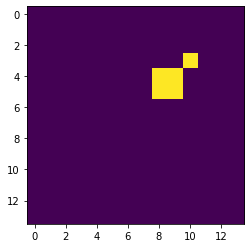

In [19]:
thresh = res.x.max()/10
idx = np.where(res.x>thresh)
print(f'high intensity location:\n {x_q[idx[0]]}')
plt.imshow((res.x>thresh).reshape(source_div_num, source_div_num))
for it in world.sources:
    print(it)